<a href="https://colab.research.google.com/github/pallavi-allada/EIP/blob/master/Session3/MNIST_Addition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F


In [90]:
# train = datasets.MNIST('', train=True, download=True)
# test = datasets.MNIST('', train=False, download=True)
# len(train),len(test), type(train), type(test)


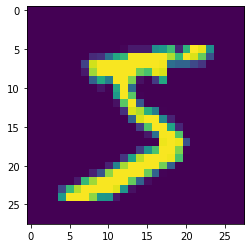

In [91]:
test[0][0]
from matplotlib.pyplot import imshow
imshow(test[0][0])
imshow(train[0][0])

In [92]:
#Custom Dataset
from torch.utils.data import Dataset
from random import randint

class CustomMNIST_Dataset(Dataset):
  def __init__(self, istrain=True):
    self.data = datasets.MNIST('', train=istrain, download=True , 
                               transform = transforms.Compose([
                                   transforms.ToTensor()]))
    self.one_hot = F.one_hot(torch.tensor([0,1,2,3,4,5,6,7,8,9]), num_classes=10)
  
  def __getitem__(self, idx):
    num = randint(0,9)
    rand_onehot = self.one_hot[num]
    img = self.data[idx][0]
    lbl = self.data[idx][1]
    sum = lbl + num
    return (img,rand_onehot,lbl,sum)

  def __len__(self):
    return len(self.data)



In [93]:
CustomMNIST_Dataset(True).__len__()

60000

In [94]:
img, rand_onehot, lbl, sum = CustomMNIST_Dataset(True).__getitem__(99)
print(img.shape, rand_onehot, lbl, sum)

torch.Size([1, 28, 28]) tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]) 1 7


In [95]:
device=""
if torch.cuda.is_available():
  device = 'cuda:0'
print(device)

cuda:0


In [96]:
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)
        self.onehot = F.one_hot(torch.tensor([0,1,2,3,4,5,6,7,8,9]), num_classes=10)
        self.FC1 = nn.Linear(in_features=20, out_features=24)
        self.FC2 = nn.Linear(in_features=24, out_features=19)
  
  def forward(self, img, num_one_hot):
        img = self.pool1(F.relu(self.conv2(F.relu(self.conv1(img)))))
        img = self.pool2(F.relu(self.conv4(F.relu(self.conv3(img)))))
        img = F.relu(self.conv6(F.relu(self.conv5(img))))
        img = F.relu(self.conv7(img))
        img = img.view(-1, 10)
        
        mnist_out =  F.log_softmax(img, dim=1)
        print(mnist_out.shape)

        #Convert the MNIST o/p to one-hot encoded format
        mnist_one_hot = self.onehot[mnist_out.argmax(dim=1)]
        mnist_one_hot = mnist_one_hot.to(device)
        concatenated = torch.cat((mnist_one_hot, num_one_hot), dim=1)

        # print(concatenated)
        concatenated = self.FC1(concatenated)
        concatenated = self.FC2(concatenated)
        sum_out = F.softmax(concatenated,dim=1)
        
        return mnist_out, sum_out



In [97]:
import torch.optim as optim
from torch.utils.data import DataLoader

torch.set_grad_enabled(True) 
train_data = DataLoader(CustomMNIST_Dataset(True), batch_size=1000, shuffle = True)
network = Net()
network.to(device)
optimizer = optim.Adam(network.parameters(), lr=0.05)


In [ ]:
for epoch in range(20):
  
  total_loss = 0
  total_correct = 0
  total_correct_sum = 0

  for batch in train_data: 
      img, rand_onehot, lbl, sum = batch
      rand_onehot = torch.tensor(rand_onehot,dtype=torch.float32)
      
      img, lbl = img.to(device), lbl.to(device)
      rand_onehot , sum  = rand_onehot.to(device) , sum.to(device)
      # print(img.dtype,lbl.dtype,rand_onehot.dtype,sum.dtype)
      # print(img,lbl,rand_onehot,sum)
  
      pred_image, pred_sum = network(img,rand_onehot)
       
      loss1 = F.cross_entropy(pred_image, lbl)
      loss2 = F.cross_entropy(pred_sum, sum)
      Loss = loss1 + loss2
    
      optimizer.zero_grad()
      Loss.backward() # Calculate Gradients
      
      optimizer.step() # Update Weights        

      total_loss += Loss.item()
           
      total_correct += pred_image.argmax(dim=1).eq(lbl).sum().item()
      total_correct_sum += pred_sum.argmax(dim=1).eq(sum).sum().item()
      
  ImageAccuracy = (total_correct/60000)*100;
  SumAccuracy = (total_correct_sum/60000)*100;
  print(
      "\n\nEpoch: ", epoch,
      "\nBatch Size: ",1000,
      "\nPredicted image Count: ", total_correct,
      "Predicted sum Count: ", total_correct_sum,
      #"loss_1:", total_loss1,
      "\nTotal loss:", total_loss,
      "\nImage Accuracy: ",ImageAccuracy,"Sum Accuracy: ", SumAccuracy
  )